This provides a framework to construct deep neural networks used to efficiently approximating various functions.
* **modular design**: builds on simple network operations and can be easily adapted and extended
* **versatile usage**: convenient mathematical notation and compatible with usual TensorFlow 2.0 modules

Theory: 

* [[1]](https://arxiv.org/abs/1709.05289): *Optimal approximation of piecewise smooth functions using deep ReLU neural networks*

  Philipp Petersen, Felix Voigtlaender
* [[2]](https://arxiv.org/abs/1905.04992): *Towards a regularity theory for ReLU networks -- chain rule and global error estimates*
  
  Julius Berner, Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen 

* [[3]](https://arxiv.org/abs/1809.07669): *DNN Expression Rate Analysis of High-dimensional PDEs: Application to Option Pricing*

  Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen, Christoph Schwab

* [[4]](https://arxiv.org/abs/1902.07896): *Error bounds for approximations with deep ReLU neural networks in $W^{s,p}$ norms*

  Ingo Gühring, Gitta Kutyniok, Philipp Petersen

* [[6]](https://arxiv.org/abs/1610.01145): *Error bounds for approximations with deep ReLU networks*

  Dmitry Yarotsky

* [[7]](https://arxiv.org/abs/1602.04485): *Benefits of depth in neural networks*

  Matus Telgarsky

* [[8]]((https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf): *Deep ReLU Networks and High-Order Finite Element Methods*
  
  Joost Opschoor, Philipp Petersen, Christoph Schwab

## Imports

In [1]:
from __future__ import (absolute_import, division, 
                        print_function, unicode_literals)
%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import HTML, SVG, display

from tensorflow.keras import layers
from tensorflow import nn
tf.keras.backend.clear_session()  # For easy reset of notebook state.

TensorFlow 2.x selected.


In [2]:
# using files github repository
!rm -r oberwolfach_workshop
!git clone https://github.com/juliusberner/oberwolfach_workshop.git

Cloning into 'oberwolfach_workshop'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 19 (delta 3), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (19/19), done.


## Neural Network Parametrizations, Realizations, and Derivatives  

We follow a mathematical definition due to [P. Petersen and F. Voigtländer [1]](https://arxiv.org/abs/1709.05289):

1. For a given architecture $N=(N_0,\dots,N_L)$ define a neural network parametrization $\Phi$ to be a finite sequence of matrix-vector pairs
    
   $$\color{green} {\Phi:=((W_k,b_k))_{k=1}^L} $$
   
   where  $W_k\in\mathbb{R}^{N_{k-1}\times N_{k}}$ and $b_k\in\mathbb{R}^{N_k}$.
    
    
2. For a given activation function $\rho\colon\mathbb{R}\to\mathbb{R}$ define its realization $\mathcal{R}_\rho\Phi\colon \mathbb{R}^{1\times N_0}\to\mathbb{R}^{1\times N_L}$ by 

    $$\color{green}{\mathcal{R}_\rho\Phi := \mathcal{A}_L\circ \rho \circ\,\mathcal{A}_{L-1}   \circ\ldots\circ \rho\circ\,\mathcal{A}_1}$$ 

  with $\color{green}{\mathcal{A}_k(x):=xW_k + b_k}$ and $\rho$ applied componentwise. 
  
  Note: In order to stay compatible with TensorFlow we multiply the input from left as a row vector.


3. Define the derivative (w.r.t. the input) $\mathcal{D}_\rho\Phi\colon\mathbb{R}^{1\times N_0}\to\mathbb{R}^{N_L\times N_0}$ by 

  $$\color{green}{\mathcal{D}_\rho\Phi:=W^T_L\cdot \operatorname{diag}(D\rho(\mathcal{R}^{L}_\rho\Phi))\cdot W^T_{L-1}\cdot\ldots\cdot \operatorname{diag}(D\rho(\mathcal{R}_\rho^{1}\Phi))\cdot W_1^T}$$ 
  
  with $\color{green}{\mathcal{R}^K_\rho\Phi:=\mathcal{R}_\rho((W_k,b_k))_{k=1}^{K}}$ and $D\rho$ applied componentwise.

  Note: If $\rho$ is only a.e. differentiable (i.e. locally Lipschitz continuous) we use the extended derivative 

  $$\bar{D}\rho(x) := \begin{cases} D\rho(x), & \rho \text{ is differentiable at } x \\ 0 &\text{else.}  \end{cases} $$

  Then it holds that the classical derivative of the realization function  coincides with the  neural network derivative almost everywhere, i.e. 

  $$\color{green}{\mathcal{D}_\rho\Phi=D\mathcal{R}_\rho\Phi \quad a.e.}$$

  see [[2]](https://arxiv.org/abs/1905.04992). Observe that all realizations with locally Lipschitz continuous activation function are itself locally Lipschitz continuous and a.e. classically differentiable (due to Rademacher's theorem) with its weak derivative a.e. coinciding with its classical derivative.

### Parametrizations
* theory: [[1]](https://arxiv.org/abs/1709.05289)

In [0]:
# Parametrization class
class P():

  def __init__(self, name_or_parameters, name='parametrization', eps=1e-6):
    if isinstance(name_or_parameters, str):
      name = name_or_parameters
      name_or_parameters = SimpleParametrizations[name_or_parameters]
    self.eps = eps
    self.name = name
    self.parameters = name_or_parameters

  @property
  def weights(self):
    return [W for W, _ in self.parameters]
  @property
  def biases(self):
    return [B for _, B in self.parameters]
  @property
  def in_dim(self):
    return self.weights[0].shape[0]
  @property
  def arch(self):
    return [self.in_dim]+[len(B) for B in self.biases]
  @property
  def out_dim(self):
    return self.arch[-1]
  @property
  def width(self):
    return max(self.arch)
  @property
  def depth(self):
    return len(self.arch)-1
  @property
  def pa_max(self):
    return max([max(np.max(W),np.max(B)) for W, B in self.parameters])
  @property
  def num_parameters(self):
    return sum([self.arch[i]*self.arch[i+1]+self.arch[i+1] 
                             for i in range(self.depth)])
  @property
  def connectivity(self):
    return sum([(np.abs(W)>self.eps).sum()+(np.abs(B)>self.eps).sum() 
                            for W, B in self.parameters])
    
  def __getitem__(self, idx):
      return self.parameters[idx]

  def __setitem__(self, idx, value):
      self.parameters[idx] = value

  def __repr__(self):
    return str(self.parameters)
  
  def __str__(self):
    return str(self.parameters)

  def attributes_print(self):
    print('Depth: {}, Width: {}, Max: {}, #Parameters: {}, Connectivity: {}'.format(
        self.depth,self.width,self.pa_max, self.num_parameters,self.connectivity))

# Parametrizations of simple functions
SimpleParametrizations = {'abs': [(np.array([[1.,-1]]), np.array([0.,0.])), 
                                  (np.array([[1.],[1.]]), np.array([0.]))],
                          'triangle': [(np.array([[1.,1.,1.]]), 
                                  np.array([0.,-0.5,-1.])), 
                                 (np.array([[2.],[-4.],[2.]]), 
                                  np.array([0.]))]}

### Realization
* tf: https://www.tensorflow.org/guide/keras/custom_layers_and_models
* theory: [[1]](https://arxiv.org/abs/1709.05289)

In [0]:
# affine linear layer
# e.g. Affine(W,B)(x)=xW+B
class Affine(layers.Layer):

  def __init__(self, W, B):
    super(Affine, self).__init__()
    self.w = tf.Variable(initial_value=tf.constant(W,dtype='float32'),
                         trainable=True)
    self.b = tf.Variable(initial_value=tf.constant(B,dtype='float32'),
                         trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

# realization map
class R(tf.keras.Model):

  def __init__(self, name_or_P, act=nn.relu):
    if isinstance(name_or_P, str):
      name_or_P=P(name_or_P)
    super(R, self).__init__(name=name_or_P.name)
    self.parametrization = name_or_P
    self.act = act
    self.affine_maps = [Affine(W, B) 
                        for W, B in self.parametrization.parameters]

  def call(self, input_tensor, training=False):

    x = input_tensor
    for affine in self.affine_maps[:-1]:
      x = affine(x)
      x = self.act(x)
    return self.affine_maps[-1](x)


### Derivative map 
* tf: https://www.tensorflow.org/tutorials/customization/autodiff
* theory: [[2]](https://arxiv.org/abs/1905.04992)

In [0]:
# derivative map (for now: only supports Pa with Pa.out_dim = 1) 
# dR(Pa)(x)/dx via automatic differentiation
def D(Pa, act=nn.relu):
  def der(x):
    with tf.GradientTape() as t:
      x = tf.convert_to_tensor(x)
      t.watch(x)
      y = R(Pa, act = act)(x)
      return t.gradient(y, x)
  return der

### Helper Functions

In [0]:
# print 1-dimensional functions
def print_1d(*functions, interval=[-1,1], titles=[''], xlabels=[''], 
             ylabels=[''], sharey=True, figsize=[10,5], num=500):
  num_plots = len(functions)
  fig, axs = plt.subplots(1, num_plots, sharey=sharey, figsize=figsize)
  x_ev=np.linspace(interval[0],interval[1],num=num,
                    dtype=np.float32)[:,np.newaxis]
  for obj in [titles,xlabels,ylabels]:
    obj+=['']*(num_plots-len(obj))
  for ax, function_list, title, xlabel, ylabel in zip(np.atleast_1d(axs), 
                                                      functions, titles, 
                                                      xlabels, ylabels):
    for f in np.atleast_1d(function_list):
      ax.plot(x_ev,f(x_ev),linewidth=2)
      ax.set_title(title)   
      ax.set_xlabel(xlabel)
      ax.set_ylabel(ylabel)   
  plt.show()

### Testing

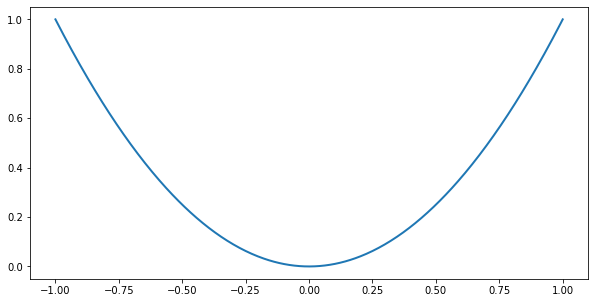

In [7]:
# testing the printing function
print_1d(lambda x: x**2)

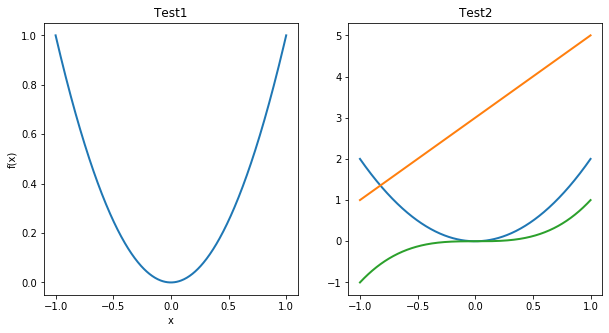

In [8]:
print_1d(lambda x: x**2, [np.poly1d([2,0,0]), np.poly1d([2,3]), lambda x: x**3], 
         titles=['Test1','Test2'], 
         xlabels=['x'], ylabels=['f(x)'], sharey=False)

In [0]:
# 2-layer net
A1 = np.array([[1.,2.,3.,4.]])
B1 = np.array([5.,6.,7.,8.])
A2 = np.array([[0.9],[0.10],[0.11],[0.12]])
B2 = np.array([0.13])
Phi = P([(A1,B1),(A2,B2)])

In [10]:
Phi

[(array([[1., 2., 3., 4.]]), array([5., 6., 7., 8.])), (array([[0.9 ],
       [0.1 ],
       [0.11],
       [0.12]]), array([0.13]))]

In [11]:
Phi.attributes_print()

Depth: 2, Width: 4, Max: 8.0, #Parameters: 13, Connectivity: 13


In [12]:
vars(Phi)

{'eps': 1e-06,
 'name': 'parametrization',
 'parameters': [(array([[1., 2., 3., 4.]]), array([5., 6., 7., 8.])),
  (array([[0.9 ],
          [0.1 ],
          [0.11],
          [0.12]]), array([0.13]))]}

In [0]:
Phi.name = 'Phi'

In [14]:
Phi.name 

'Phi'

In [15]:
dir(Phi)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'arch',
 'attributes_print',
 'biases',
 'connectivity',
 'depth',
 'eps',
 'in_dim',
 'name',
 'num_parameters',
 'out_dim',
 'pa_max',
 'parameters',
 'weights',
 'width']

In [16]:
Phi.arch

[1, 4, 1]

In [17]:
R(Phi)([[2.]])

<tf.Tensor: id=43, shape=(1, 1), dtype=float32, numpy=array([[10.78]], dtype=float32)>

In [18]:
R(Phi)([[2.],[3.],[4.]])

<tf.Tensor: id=87, shape=(3, 1), dtype=float32, numpy=
array([[10.78    ],
       [12.69    ],
       [14.599999]], dtype=float32)>

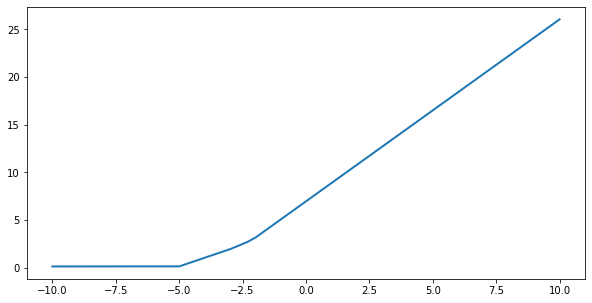

In [19]:
print_1d(R(Phi), interval=[-10,10])

In [0]:
Phi[1]=(np.array([[3.], [1.], [4.], [1.]]), np.array([5.]))
#equivalent: Phi.parameters[1]

In [21]:
Phi

[(array([[1., 2., 3., 4.]]), array([5., 6., 7., 8.])), (array([[3.],
       [1.],
       [4.],
       [1.]]), array([5.]))]

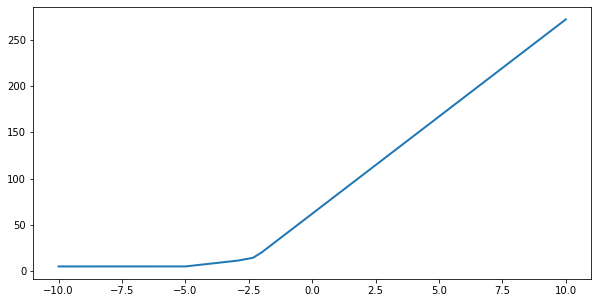

In [22]:
print_1d(R(Phi), interval=[-10,10])

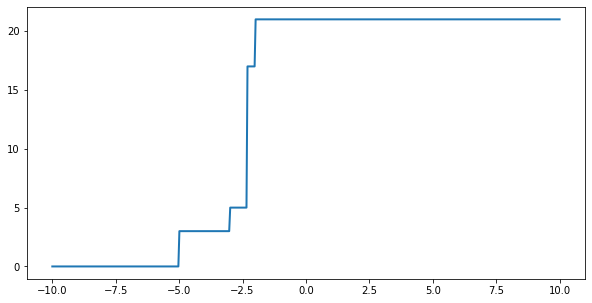

In [23]:
print_1d(D(Phi), interval=[-10,10])

## Operations on Parametrizations

We can define various operations on neural networks parametrizations achieving 
* Concatenation (Composition)
* Parallelization
* Affine Combinations

of the corresponding trealization functions.

For instance, we define the concatenation with $\Psi\!=\!((\tilde{A}_k,\tilde{b}_k))_{k=1}^{\tilde{L}}$ by


 $$\Psi\circ\Phi:=\big(((A_k,b_k))_{k=1}^{L-1},(A_{L}\tilde{A}_1,b_{L}^T\tilde{A}_1 +\tilde{b}_1),((\tilde{A}_k,\tilde{b}_k))_{k=2}^{\tilde{L}}\big)$$


and it holds that $\mathcal{R}_\rho(\Psi\circ\Phi) = \mathcal{R}_\rho(\Psi) \circ\mathcal{R}_\rho (\Phi)$.



In the following we focus on the ReLU activation function $\color{green}{\rho(x)=\operatorname{ReLU}(x):=x_+}$.

Note that such constructions could be achieved for any piecewise linear activation function with $1\le M <\infty$ breakpoints [[6]](https://arxiv.org/abs/1610.01145) and in an approximative fashion for any activation function that is differentiable and not constant on some open set (as this allows the uniform approximation of the identity function on a compact set).

### Helper functions

In [0]:
# blockdiagonal matrix
def blockdiag(matrix_list):
  if len(matrix_list)==2:
    m1 = matrix_list[0]
    m2 = matrix_list[1]
    return np.block([[m1,np.zeros((m1.shape[0],m2.shape[1]))],
                     [np.zeros((m2.shape[0],m1.shape[1])),m2]])
  else:
    return blockdiag([blockdiag(matrix_list[:-1]),matrix_list[-1]])

### NN operations and constructions
* theory: [[1]](https://arxiv.org/abs/1709.05289), [[3]](https://arxiv.org/abs/1809.07669), [[4]](https://arxiv.org/abs/1902.07896)

In [0]:
# linear network
def Lin(W):
  zeros = np.zeros((W.shape[1],))
  return P([(W,zeros)])

# network concatenation
# e.g. Pa_list = [Pa1, Pa2, Pa3]
# R(Conc(Pa_list))(x)=R(Pa3)(R(Pa2)(R(Pa1)(x)))
# the order is reversed for easier usage
def Conc(Pa_list):
  if len(Pa_list)==1: #catch exceptional cases in other functions
    return Pa_list[0]
  if len(Pa_list)==2:
    Pa1=Pa_list[0]
    Pa2=Pa_list[1]
    W=np.matmul(Pa1.weights[-1],Pa2.weights[0])
    B=np.matmul(Pa1.biases[-1],Pa2.weights[0])+Pa2.biases[0]
    return P(Pa1.parameters[:-1]+[(W,B)]+Pa2.parameters[1:])
  else:
    return Conc([Conc(Pa_list[:-1]),Pa_list[-1]])

# positive elongation (with factor) helper function
def _pos_elong(Pa, L, factor = 1):
  Pa_pos = Identity(Pa.out_dim, 1, scale = factor)
  return P(Pa.parameters+[Pa_pos.parameters[0] for _ in range(L-Pa.depth)])

# (affine) linear combination
# e.g. Pa_list = [P1,P2], coeff_list = [A,B]
# then: R(Affine(Pa_list, coeff_list))(x)=A*R(P1)(x)+B*R(P2)(x))
# see parallelization for explanation of ind_list
def Affine_Comb(coeff_list, Pa_list = None, ind_list = None, affine = None):
  block = np.block([coeff_list]).transpose()
  if affine == None:
    Pa_comb = Lin(block)
  else:
    Pa_comb = P([(block,affine)])
  if Pa_list == None:
    return Pa_comb
  else: 
    return Conc([Par(Pa_list, ind_list=ind_list),Pa_comb])

# identity network with possible efficient scaling
# e.g. dim=2, L=4, scale = np.array([16,81]) 
# then R(Identity(dim, L, scale))(x)=(16x_1,81x_2)
# efficient: coefficients with magnitude |scale_i|**(1/L)
def Identity(dim, L, scale = 1):
  id = np.eye(dim)
  if L==1:
    return Lin(scale*id)
  elif L>1:
    factor = np.abs(scale)**(1/L)
    Pa_list = [_pos_elong(Lin(m), L, factor=factor) 
              for m in [factor*id, -factor*id]]
    ind = np.arange(dim)
    return Affine_Comb([np.sign(scale)*id, -np.sign(scale)*id], Pa_list=Pa_list, ind_list=[ind, ind])
  else:
    raise ValueError('L must be a natural number greater than 0.')

# update SimpleParametrizations
SimpleParametrizations.update({'identity': Identity(1,1).parameters})

# parallelization helper function for same depth
def _par_same(Pa_list):
  if len(Pa_list)==2:
    return P([(blockdiag([W1,W2]),np.block([B1,B2])) 
            for (W1, B1), (W2, B2) 
            in zip(Pa_list[0].parameters,Pa_list[1].parameters)])
  else:
    return _par_same([_par_same(Pa_list[:-1]),Pa_list[-1]])

# parallelization with indexed input
# e.g. Pa_list = [P1,P2], ind_list = [(2,0),(1,3)]
# then: R(Par(Pa_list, ind_list))(x_0,x_1,x_2,x_3)=(R(P1)(x_2,x_0),R(P2)(x_1,x_3))
def Par(Pa_list, ind_list = None, in_dim = None):
  L = max([Pa.depth for Pa in Pa_list])
  Pa = _par_same([Elongation(Pa, L) for Pa in Pa_list])
  if ind_list == None:
    return Pa
  else:
    if in_dim == None:
      in_dim = max([max(ind) for ind in ind_list])+1
    perms = [np.zeros((in_dim, Pa.in_dim)) for Pa in Pa_list]
    for perm, ind in zip(perms, ind_list):
      perm[ind,np.arange(len(ind))] = 1
    Pa_perms = Lin(np.block([perms]))
    return Conc([Pa_perms,Pa])

# sparse network concatenation
def Sparse_Conc(Pa_list):
  if len(Pa_list)==2:
    Id = Identity(Pa_list[0].out_dim, 2)
    return Conc([Pa_list[0],Id,Pa_list[1]])
  else:
    return Sparse_Conc([Sparse_Conc(Pa_list[:-1]),Pa_list[-1]])

# network elongation
def Elongation(Pa, L): 
  if Pa.depth == L:
    return Pa
  else:
    return Conc([Pa,Identity(Pa.out_dim,L-Pa.depth+1)])

### Testing

In [0]:
T, I = P('triangle'), P('identity')

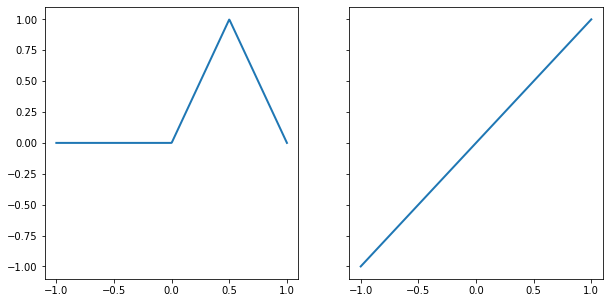

In [27]:
print_1d(R(T),R(I))

In [28]:
I.attributes_print()

Depth: 1, Width: 1, Max: 1.0, #Parameters: 2, Connectivity: 1


In [0]:
I_long = Elongation(I, 2)

In [30]:
I_long.attributes_print()

Depth: 2, Width: 2, Max: 1.0, #Parameters: 7, Connectivity: 4


In [31]:
Pa2 = Affine_Comb([1.,1.], Pa_list=[I,T], ind_list=[[0],[0]])
Pa2

[(array([[ 1., -1.,  1.,  1.,  1.]]), array([ 0. ,  0. ,  0. , -0.5, -1. ])), (array([[ 1.],
       [-1.],
       [ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

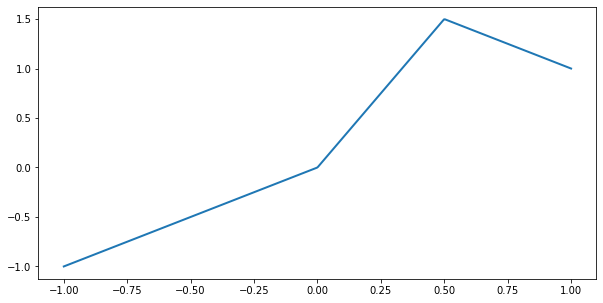

In [32]:
print_1d(R(Pa2))

In [0]:
Pa2 = Affine_Comb([1.,1.], Pa_list=[I,T])

In [34]:
Pa2.in_dim, Pa2.out_dim

(2, 1)

In [35]:
R(Pa2)([[0.25,0.25]]).numpy()

array([[0.75]], dtype=float32)

In [36]:
D(Pa2)([[0.25,0.25]]).numpy()

array([[1., 2.]], dtype=float32)

## (Constructive) Approximation Results in $W^{1,\infty}$ norm

In the following we show how to approximate a richer class of functions by ReLU networks with "almost optimal" rates (in the spirit of [Yarotsky [6]](https://arxiv.org/abs/1610.01145)).

### Telgarsky Saw-Tooth Construction 

*For any positive integer k, there exist neural networks with $\mathcal{O}(k^3)$  layers, $\mathcal{O}(1)$ nodes per layer, and $\mathcal{O}(1)$ distinct parameters which can not be approximated by networks with $\mathcal{O}(k)$ layers unless they are exponentially large --- they must possess $\Omega(2^k)$ nodes [[7]](https://arxiv.org/abs/1602.04485).*

Each application of the triangle ReLU network doubles the number of "theeth"  $\Rightarrow$  $\color{green}{2^k}$ teeth with $\color{green}{\mathcal{O(k)}}$ network size (layers/parameters)

In [37]:
interact(lambda k: print_1d(R(Conc([P('triangle') for _ in range(k)])), 
                            interval=[0,1]), k=(1,5), num=20000);

interactive(children=(IntSlider(value=3, description='k', max=5, min=1), Output()), _dom_classes=('widget-inte…

### Yarotsky Squaring Network 

*Proposition 2. The function $f (x) = x^2$ on the segment [0, 1] can be approximated with any
error $\varepsilon > 0$ by a ReLU network having the depth and the number of weights and computation
units $\mathcal{O}(ln(1/\varepsilon))$ [[6]](https://arxiv.org/abs/1610.01145).*

* $\big($ linear interpolations of $f$ on intervals of size $2^{-k}$ $\big)$ - $\big($ linear interpolation on intervals of size $2^{-(k+1)}$  $\big)$ 

  $= \big($ scaled saw-thooth function with $2^k$ "theeth" $\big)$

* "on the fly" add the scaled sawthooth functions in an additional node $\Rightarrow$ precision $\color{green}{\mathcal{O}(2^{-k})}$ with ReLU networks of size $\color{green}{\mathcal{O}(k)}$

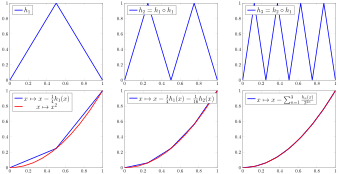

In [38]:
# squaring helper function (interpolates the squaring function up to precision 4**(-k))
def _square(k):
  if k==1:
    return P('identity')
  elif k>1:
    Pa_triang = P('triangle')
    Pa_inp = _pos_elong(P('identity'), 2)
    Pa_sub_list = [_pos_elong(Affine_Comb([-2.**(-2*m),1]), 2) for m in range(1,k-1)]
    Pa_first = Par([Pa_triang, Pa_inp], ind_list=[[0],[0]])
    Pa_middle_list = [Par([Pa_triang, Pa_sub], ind_list=[[0],[0,1]]) 
                      for Pa_sub in Pa_sub_list]
    return Conc([Pa_first]+Pa_middle_list+[Affine_Comb([-2.**(-2*(k-1)),1])])
  else:
    raise ValueError('k must be a natural number greater than 0.')

SVG('oberwolfach_workshop/figures/square_approx.svg')

In [39]:
square = np.poly1d([1,0,0])
interact(lambda k: print_1d([R(_square(k)),square], interval=[0,1]), k=(1,5));

interactive(children=(IntSlider(value=3, description='k', max=5, min=1), Output()), _dom_classes=('widget-inte…

*...the same construction can be used when measuring the
approximation error in the $W^{1,\infty}$ norm. In particular, the depth and the number of weights and neurons
of the network do not grow asymptotically faster to satisfy the approximation accuracy with respect to
this stronger norm.* [[4]](https://arxiv.org/abs/1902.07896), [[8]](https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf)

Let $f(x)=x^2$. There are ReLU networks $\Phi_\varepsilon$ of size $\color{green}{\mathcal{O(\log(1/\varepsilon))}}$ satisfying $\color{green}{\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1))} \le \varepsilon}$.



----

**Reminder:** 

$$ W^{n,p}(\Omega):= \{g\in L^p(\Omega): D^\alpha g \in L^p(\Omega)  \quad \forall\alpha\in\mathbb{N}_0^d \quad \text{with} \quad |\alpha|\le n\}$$

$D^\alpha g$ is the $\alpha$-th weak derivatives of $g$, if $$\int_{\Omega} g (D^{\alpha} \phi) = (-1)^{|\alpha|} \int_{\Omega} (D^{\alpha} g) \phi$$ for all $\phi\in C^\infty_c(\Omega)$.

---



$$\|g\|_{W^{n,\infty}(\Omega)}:=\max_{0\le|\alpha|\le n} \|D^{\alpha} g\|_{L^\infty(\Omega)}$$


---


$\big($ $\Phi$ approximates $f$ in $W^{1,\infty}$ $\big)$ $\Leftrightarrow$ $\big($ $\mathcal{R}(\Phi)$ and its weak gradient uniformly approximate f and the weak gradient of f , respectively $\big)$

---

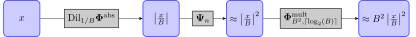

In [40]:
# approximation of squaring function on [-B,B] 
# up to error eps in Sobolev W^{1,\infty} norm
def Square(eps, B = 1.):
  k = int(np.ceil(2*np.log2(B/eps)+1))
  L = int(np.ceil(np.log2(B))) if B>1 else 1
  return Conc([Lin(np.array([[1/B]])),P('abs'),
                _square(k),Identity(1, L, scale=B**2)])

SVG('oberwolfach_workshop/figures/square.svg')

In [41]:
# visualization of squaring function approximation
interact(lambda eps: print_1d([R(Square(eps)),square],
                              [D(Square(eps)),np.polyder(square)], 
                              interval=[-1,1], sharey=False), eps=(0.1,1.));

interactive(children=(FloatSlider(value=0.55, description='eps', max=1.0, min=0.1), Output()), _dom_classes=('…

In [42]:
# exploring the squaring function approximation networks
interact(lambda eps, B: Square(eps, B = B).attributes_print(), 
         eps=(0.01,0.1,0.01), B=(1.,100.));

interactive(children=(FloatSlider(value=0.05, description='eps', max=0.1, min=0.01, step=0.01), FloatSlider(va…

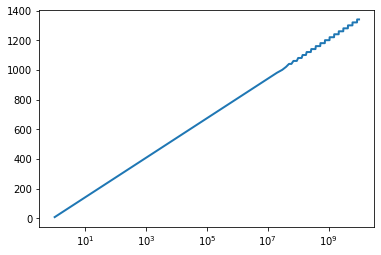

In [43]:
# emprical test of parameter scaling
x = np.linspace(1, 1e10, num=1000)
y = [Square(1/eps).num_parameters for eps in x]
plt.semilogx(x,y,linewidth=2)

### Multiplication, Polynomials, and Smooth Functions

Combing (composition, linear combination) the squaring networks (and exactly representable easy networks) one gets 
* networks approximating multiplication: $\color{green}{xy=\left|\frac{x+y}{2}\right|^2-\left|\frac{x-y}{2}\right|^2}$
* polynomials 
* functions whose first $n\geq 1$ (weak) derivatives are bounded: local Taylor approximation



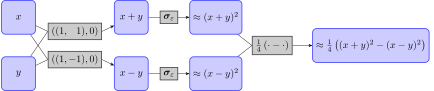

In [44]:
# approximation of multiplication function on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Mult(eps, B = 1.):
  Pa_list = [Conc([Affine_Comb([1., a]), Square(2*eps, B = 2*B)]) 
            for a in [1.,-1.]]
  return Affine_Comb([0.25,-0.25], Pa_list=Pa_list, ind_list=[[0,1],[0,1]])

SVG('oberwolfach_workshop/figures/mult.svg')

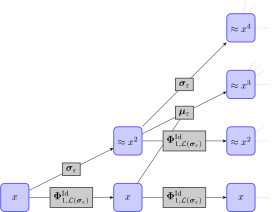

In [45]:
# approximation of monomials function (x,x^2,...,x^(2^2)) on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def _Monomial(K, eps, B = 1.):
  Pa_list_all=[]
  Pa_id = P('identity')
  eta = eps/(4.**(K**2)*B**(2**(K+1)))
  eta_list = [4**(k**2)*eta for k in range(1,K+1)]  
  E = 2*B**(2**K)
  for k in range(K):
    Pa_list=[]
    ind_list=[]
    Pa_square = Square(eta_list[k], B = E)
    Pa_mult = Mult(eta_list[k], B = E)
    for i in range(2**(k+1)):
      if i<=2**k-1:
        Pa_list.append(Pa_id)
        ind_list.append([i])
      elif i%2:
        Pa_list.append(Pa_square)
        ind_list.append([(i-1)//2])
      else:
        Pa_list.append(Pa_mult)
        ind_list.append([(i-2)//2,i//2])
    Pa_list_all.append(Par(Pa_list, ind_list=ind_list))
  return Conc(Pa_list_all)

SVG('oberwolfach_workshop/figures/monomials.svg')

In [46]:
# Testing the output
R(_Monomial(3, 0.1, B=10.))([[3.]]).numpy()

array([[3.0000000e+00, 8.9999981e+00, 2.7000015e+01, 8.0999947e+01,
        2.4300027e+02, 7.2900079e+02, 2.1870010e+03, 6.5609907e+03]],
      dtype=float32)

In [0]:
# Monomial extension: arbitrary degree deg, optional with constant 1
def Monomial(deg, eps, B=1.0, const=True):
  K = int(np.ceil(np.log2(deg)))
  if const:
    e = np.zeros((deg+1,))
    e[0] = 1
    Pa_zero = P([(np.block([np.zeros((2**K,1)),np.eye(2**K,deg)]),e)])
  else:
    Pa_zero = Lin(np.eye(2**K,deg))
  return Conc([_Monomial(K, eps, B), Pa_zero])

In [48]:
# Testing the output
interact(lambda const: print(R(Monomial(3, 0.1, B=10., const = const))([[3.]]).numpy()), 
         const=True);

interactive(children=(Checkbox(value=True, description='const'), Output()), _dom_classes=('widget-interact',))

In [0]:
# approximation of polynomial p[0]*x^(N-1)+ ... +p[N-1] on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Poly(p, eps, B = 1.):
  p_len = len(p)
  coeff_sum = np.sum(np.abs(p))
  eta = eps/coeff_sum
  L = int(np.ceil(np.log2(coeff_sum)))
  Pa_scale = Identity(p_len, L, scale=p[::-1])
  return Conc([Monomial(p_len-1, eta, B), Pa_scale, 
               Affine_Comb(np.ones((1,p_len)))])

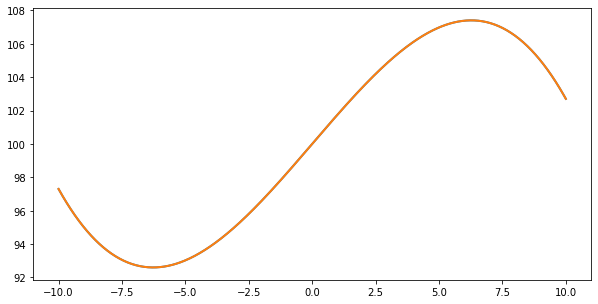

In [50]:
# visualization of polynomial approximation
p=[-0.015,0.,1.77,100.]
print_1d([R(Poly(p, eps=1., B=10.)), np.poly1d(p)], interval=[-10,10])

In [51]:
Poly(p, eps=0.001, B=10.).attributes_print()

Depth: 280, Width: 16, Max: 3.7606030930863934, #Parameters: 39019, Connectivity: 6780


## Additional Material

### ReLU derivative

**Problem: Classical Chain-Rule fails!**

...although all ReLU networks are a.e. differentiable.

Very simple counterexample: 

$u(x):=\operatorname{ReLU}(x)$

$v(x):=0$ 

formally apply the chain rule: $$D(u\circ v)(x)=\color{blue}{D u(v(x))}\cdot D v(x)$$

$D u(y)$ is well-defined for all $y\neq 0$, but the expression $\color{blue}{D u(v(x))}$ is not defined for any $x\in\mathbb{R}$.


**Inner function maps a set of positive measure into a set where the derivative of the outer function does not exist.**

---


**What happens in PyTorch / Tensorflow when computing the gradients in the back-propagation (as this is based on the chain-rule)??**

The derivative of the ReLU at zero is set to zero in PyTorch and Tensorflow, i.e.
$\color{blue}{\frac{\partial \operatorname{ReLU}}{\partial x}(x) :=1_{(0,\infty)}(x)}$

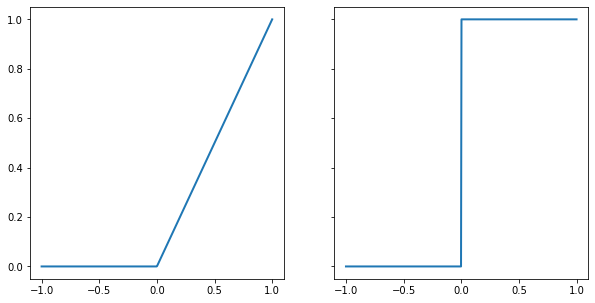

In [52]:
ReLU=P([(np.array([[1.]]),np.array([0.])),(np.array([[1.]]),np.array([0.]))])
print_1d(R(ReLU),D(ReLU))

In [53]:
D(ReLU)([[0.]])

<tf.Tensor: id=22321, shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

We already defined a derivative of a prametrization satisfying 

$$\color{green}{\mathcal{D}\Phi=D\mathcal{R}\Phi \quad a.e.}$$

(abbreviating $\mathcal{D}:=\mathcal{D}_{\operatorname{ReLU}}$, and $\mathcal{R}:=\mathcal{R}_{\operatorname{ReLU}}$).

Note that the chain rule holds by definition everywhere, i.e. 

 $$\color{green}{\mathcal{D}(\Psi\circ\Phi)=\mathcal{D}^{\mathcal{N}}\Psi(\mathcal{R}\Phi)\cdot\mathcal{D}^{\mathcal{N}}\Phi}.$$






---

**However:** On the nullset the derivative can be arbitrary wrong, e.g. take the network $\Phi=\left(\left( (1 , -1 ),(0 ,0)\right),\left( \left(\begin{matrix} a \\-b \end{matrix}\right),0\right)\right)$ then it holds:

1. $\mathcal{R}\Phi(x)=a\operatorname{ReLU}(x)-b\operatorname{ReLU}(-x)=\begin{cases}  bx, &x< 0 \\  ax, &x\ge 0 \end{cases}$
2. $ \mathcal{D}\Phi(x)=\begin{cases}  b, &x< 0 \\  a, & x> 0 \\ \color{blue}0, & x=0\end{cases}$

In [54]:
def Pa_ab(a, b):
  return P([(np.array([[1.,-1.]]),np.array([0,0])), 
            (np.array([[a],[-b]]), np.array([0.]))])
interact(lambda a, b: print_1d(R(Pa_ab(a,b)),D(Pa_ab(a,b)), sharey=False), 
         a=(1.,2.), b=(1.,2.));

interactive(children=(FloatSlider(value=1.5, description='a', max=2.0, min=1.0), FloatSlider(value=1.5, descri…

For convex $\mathcal{R}\Phi$ the values of $\mathcal{D}\Phi$ on the nullset do not necessarily lie in the respective subdifferentials of $\mathcal{R}\Phi$.

Although our results hold regardless of which value is chosen for the derivative of $\operatorname{ReLU}$ at the origin, no choice will guarantee that all values of $\mathcal{D} \Phi$ lie in the respective subdifferentials of $\mathcal{R}\Phi$.

### Theoretical Results 

**...for classes of Sobolev-regular functions:** [[4]](https://arxiv.org/abs/1902.07896)

There exists $c=c(d,n,B)\ge 0$ such that for any $\varepsilon\ge 0$ and
$$f\in\{g\in W^{n,\infty}((0,1)^d): \|g\|_{W^{n,\infty}((0,1)^d)}\le B\}$$
there exists a ReLU network $\Phi$ with
$$\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1)^d)} \le \varepsilon$$
and
$$Depth(\Phi)\le c \cdot log(\varepsilon^{-n/(n-1)}), \quad Connectivity(\Phi)\le  c \cdot \varepsilon^{-d/(n-1)} \cdot log^2(\varepsilon^{-n/(n-1)}).$$

The result holds also for:

* (fractional) Sobolev spaces $W^{s,p}$ with $0\le s \le 1$ and $1\le p \le \infty$ by a Banach space interpolation argument
* any continuous piecewise linear activation function with $1\le M < \infty$ breakpoints
* lower bound: $Connectivity(\Phi)\ge  c \cdot \varepsilon^{-d/2(n-1)}$


### Global (Pointwise) Error Estimates

For suitable functions $f$ with at most polynomially growing derivative we want ReLU networks $\Phi_\varepsilon$ with:
$$ 
|f(x)-\mathcal{R}{\Phi_\varepsilon}(x)|\le \varepsilon(1+\|x\|^{\kappa}_2) \quad \color{blue}{x\in\mathbb{R}^d}
$$
$$
    \|D f(x) -\mathcal{D}\Phi_\varepsilon(x)\|_2 \le C\varepsilon^r(1+\|x\|_2^{\kappa}) \quad \color{blue}{a.e. \ x\in\mathbb{R}^d}
$$

Idea:
1. ReLU networks $\Phi_{\varepsilon,B}$ with $\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((-B,B)^d)} \le \varepsilon$
2.  ReLU network $\Phi_B^{\operatorname{char}}$ which represents the $d$-dimensional approximate characteristic function of $[-B,B]^d$ [[3]](https://arxiv.org/abs/1809.07669)
3. ReLU network $\Phi_{\varepsilon,b}^{\operatorname{mult}}$ approximating the multiplication function on $[-b,b]^2$ with error $\varepsilon$
4. Define the global approximation networks $\Phi_\varepsilon$ as the composition of $\Phi_{\varepsilon/2,b_\varepsilon}^{\operatorname{mult}}$ with the parallelization of $\Phi_{B_\varepsilon}^{\operatorname{char}}$ and $\Phi_{\varepsilon/2,B_\varepsilon+1}$ for suitable 
\begin{equation}
    B_\varepsilon\in \mathcal{O}(\varepsilon^{-1}) \quad \text{and} \quad b_\varepsilon\in \mathcal{O}(\varepsilon^{-\nu}).
\end{equation}
